In [1]:
import numpy as np
import time
from scipy.spatial import Voronoi, Delaunay, voronoi_plot_2d
from matplotlib import cm
from collections import defaultdict
from tqdm import trange
import random
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# folder = "/content/"

# data_list = []   # store all data here

# for filename in sorted(os.listdir(folder)):
#     if filename.endswith(".txt"):
#         # extract time from filename
#         time = float(filename.replace(".txt", ""))

#         # load data (two columns: x, y)
#         filepath = os.path.join(folder, filename)
#         data = np.loadtxt(filepath)

#         x = data[:, 0]
#         y = data[:, 1]

#         # store in a dictionary
#         data_list.append({
#             "time": time,
#             "x": x,
#             "y": y,
#             "filename": filename
#         })

# # show summary
# print(f"Loaded {len(data_list)} files")

In [3]:
# # --- time array (1D) ---
# t = np.array([d["time"] for d in data_list])

# # --- r array (3D): (time_steps, points, 2) ---
# r = np.array([np.column_stack((d["x"], d["y"])) for d in data_list])
from SPV_utils import *
# folder = "./coordinate_p0=3.80_v0=0.20_pin=0_set_10/"
folder = r"N=400_pin=0\N=400\coordinate_p0=3.80_v0=0.50_pin=0_set_3/"
# folder = r"N=1024_pin=0\N=1024\coordinate_p0=3.80_v0=0.50_pin=0_set_3/"
t, r = get_data_from_folder(folder)
init_pos = r[0]    #should i take it at zero???

In [4]:
r.shape

(311, 400, 2)

In [5]:
def msd_plot(r, t):
    # r has shape (N_time, N_particles, 2)

    # --- 1. Compute COM at each time ---
    com = r.mean(axis=1, keepdims=True)         # shape: (N_time, 1, 2)

    # --- 2. Remove COM drift ---
    r_nodrift = r - com                         # drift-corrected positions

    # --- 3. Reference frame at t = 0 ---
    r0 = r_nodrift[0]                           # shape: (N_particles, 2)

    # --- 4. MSD calculation ---
    msd = np.zeros(len(t))
    for i in range(len(t)):
        ri = r_nodrift[i]
        msd[i] = np.mean(np.sum((ri - r0)**2, axis=1))

    # --- 5. Plot ---
    plt.loglog(t, msd)
    plt.xlabel("time")
    plt.ylabel("MSD")
    plt.grid(True, ls='--')
    plt.show()

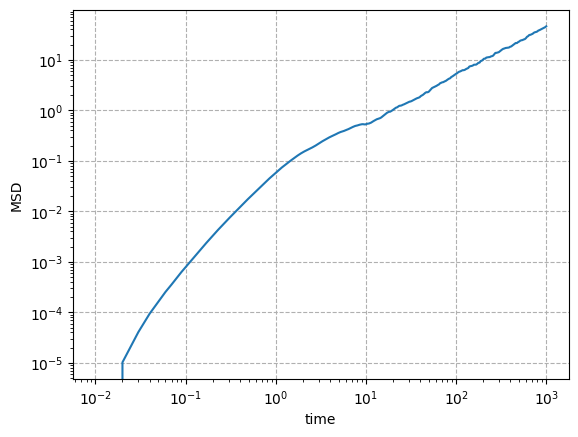

In [6]:
msd_plot(r, t)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def rdf_2d_pbc(r, Lx, Ly, r_max=10.0, dr=0.05, average_over_time=True):
    """
    r  : array of shape (T, N, 2)
    Lx : box length in x
    Ly : box length in y
    r_max : maximum distance for g(r)
    dr : bin width
    average_over_time : average over all frames
    """
    T, N, dim = r.shape

    # number density (2D)
    area = Lx * Ly
    rho = N / area

    # RDF bins
    edges = np.arange(0, r_max + dr, dr)
    centers = 0.5 * (edges[:-1] + edges[1:])
    rdf = np.zeros_like(centers)

    # loop through frames
    for ti in range(T if average_over_time else 1):
        pos = r[ti]

        # pairwise difference matrix
        diff = pos[:, None, :] - pos[None, :, :]

        # PBC minimum-image convention
        diff[:, :, 0] -= np.round(diff[:, :, 0] / Lx) * Lx
        diff[:, :, 1] -= np.round(diff[:, :, 1] / Ly) * Ly

        # distances
        dist = np.sqrt(diff[:, :, 0]**2 + diff[:, :, 1]**2)

        # use only i < j
        dist = dist[np.triu_indices(N, k=1)]

        # histogram
        hist, _ = np.histogram(dist, bins=edges)
        rdf += hist

    if average_over_time:
        rdf /= T

    # normalization (2D)
    shell_area = 2 * np.pi * centers * dr             # area of ring in 2D
    ideal = rho * shell_area * N                      # expected counts in ideal gas
    rdf /= ideal

    return centers, rdf

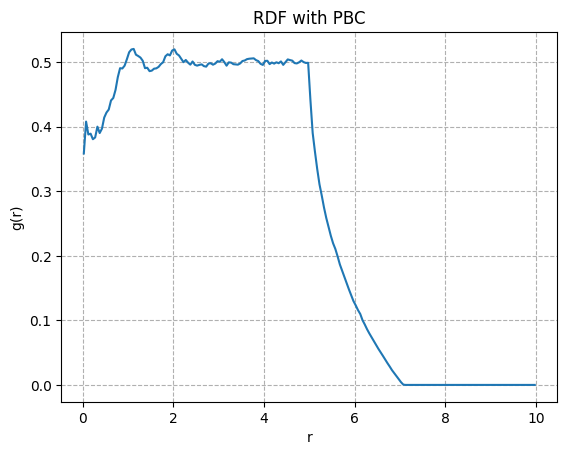

The peak in Radial distribution function is at 1.125 (0.520)


In [8]:
Lx = 10.0
Ly = 10.0

r_bins, g_r = rdf_2d_pbc(r, Lx=Lx, Ly=Ly, r_max=10, dr=0.05)

plt.plot(r_bins, g_r)
plt.xlabel("r")
plt.ylabel("g(r)")
plt.grid(True, ls='--')
plt.title("RDF with PBC")
plt.show()

val = np.argmax(g_r)
print(f'The peak in Radial distribution function is at {r_bins[val]:0.3f} ({g_r[val]:0.3f})')

In [9]:
# import numpy as np

# def structure_factor(r, Lx, Ly, k_max=20.0, dk=0.2, Nk=500):
#     T, N, _ = r.shape
#     ks = np.arange(1, k_max, dk)
#     S = np.zeros_like(ks, dtype=float)

#     angles = np.linspace(0, 2*np.pi, Nk, endpoint=False)
#     cos_theta = np.cos(angles)
#     sin_theta = np.sin(angles)

#     for t in range(T):
#         pos = r[t]  # (N,2)
#         S_t = np.zeros_like(ks)

#         for i, k in enumerate(ks):
#             # kx, ky shape = (Nk, 1)
#             kx = k * cos_theta[:, None]
#             ky = k * sin_theta[:, None]

#             # dot product k · r for all angles and particles (Nk, N)
#             phase = np.exp(-1j * (kx @ pos[:,0][None,:] + ky @ pos[:,1][None,:]))

#             # rho_k for each angle
#             rho_k = np.sum(phase, axis=1)/N
#             S_t[i] = np.mean(np.abs(rho_k)**2)

#         S += S_t

#     S /= T
#     return ks, S

In [10]:
import numpy as np

def structure_factor(r, Lx, Ly, k_max=20.0, dk=0.2, Nk=500):
    T, N, _ = r.shape
    ks = np.arange(1, k_max, dk)
    S = np.zeros_like(ks, dtype=float)

    angles = np.linspace(0, 2*np.pi, Nk, endpoint=False)
    cos_theta = np.cos(angles)
    sin_theta = np.sin(angles)

    for t in range(100):
        pos = r[t]  # (N,2)
        S_t = np.zeros_like(ks)

        for i, k in enumerate(ks):
            # kx, ky shape = (Nk, 1)
            kx = k * cos_theta[:, None]
            ky = k * sin_theta[:, None]

            # dot product k · r for all angles and particles (Nk, N)
            phase = np.exp(-1j * (kx @ pos[:,0][None,:] + ky @ pos[:,1][None,:]))

            # rho_k for each angle
            rho_k = np.sum(phase, axis=1)/N
            S_t[i] = np.mean(np.abs(rho_k)**2)

        S += S_t

    S /= 100
    return ks, S
S_k = structure_factor(r, Lx, Ly, k_max = 10, dk = 0.1, Nk = 500)

In [11]:
# import numpy as np

# def structure_factor(r, k_max=20.0, n_k=1000, n_theta=500):
#     T, N, _ = r.shape
    
#     ks = get_polar_k_grid(n_k, n_theta, k_max)[0]
    
#     S = np.zeros(ks.shape[0], dtype=float)

#     for t in range(T):
#         pos = r[t]  # (N,2)
#         for i in range(ks.shape[0]):
#             phase = np.exp(-1j * pos@ks[i].T)

#             # rho_k for each angle
#             rho_k = np.sum(phase, axis=0)/N
#             S[i] += np.mean(np.abs(rho_k)**2)


#     S /= T
#     return ks, S
# S_k = structure_factor(r, k_max=10.0, n_k = 200, n_theta = 200)

In [12]:
# S_k = display_polar_k_grid(S_k[1], get_polar_k_grid(200, 200, 10)[1])

In [13]:
r_max = 10.0   # adjust according to your system
dr = 0.05

r_bins, g_r = rdf_2d_pbc(r, Lx=Lx, Ly=Ly, r_max=r_max, dr=dr)

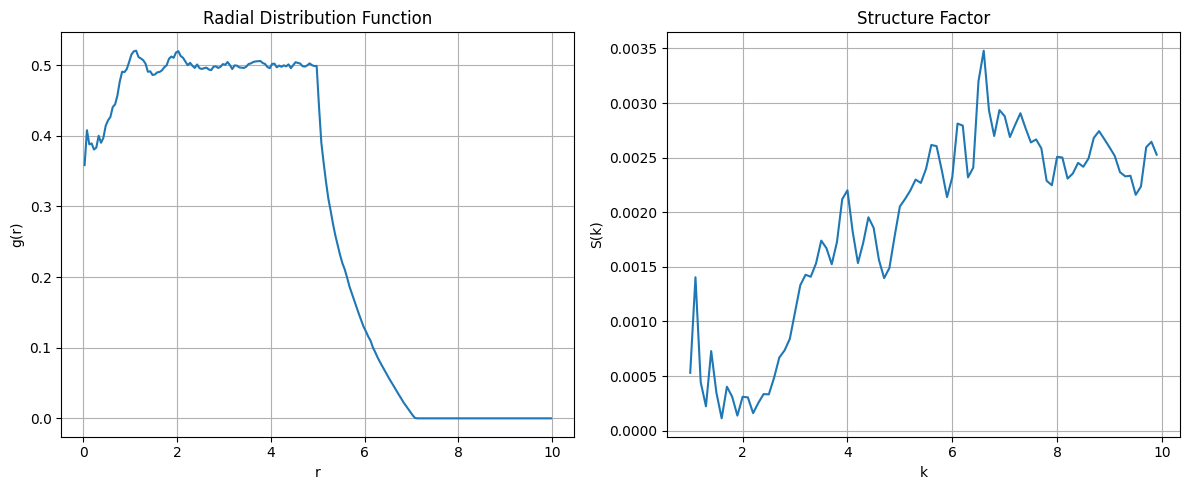

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(r_bins, g_r)
plt.xlabel("r")
plt.ylabel("g(r)")
plt.title("Radial Distribution Function")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(S_k[0], S_k[1])
plt.xlabel("k")
plt.ylabel("S(k)")
plt.title("Structure Factor")
plt.grid(True)

plt.tight_layout()
plt.savefig('rdf_sk.png', dpi=300)
plt.show()

In [15]:
val1 = np.argmax(g_r)
print(f'The peak in Radial distribution function is at {r_bins[val1]:0.3f} ({g_r[val1]:0.3f})')

The peak in Radial distribution function is at 1.125 (0.520)


In [16]:
val2 = np.argmax(S_k[1])
print(f'The peak in Structure factor is at {S_k[0][val2]:0.3f} {S_k[1][val2]:0.3f}')

The peak in Structure factor is at 6.600 0.003


In [17]:
print('Conversion check')
km = S_k[0][val2]
rm = r_bins[val1]

k_act = 2*np.pi/rm

Conversion check


In [18]:
print(f'{km:0.3f}\n{rm:0.3f}\n{k_act:0.3f}')

6.600
1.125
5.585
